<a href="https://colab.research.google.com/github/siddadel/kalidas/blob/main/Collate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
root = '/content/drive/MyDrive/ANLP21/'
out = root+"out/"

In [3]:
import pandas as pd
import random
import os
import re
import spacy
from collections import Counter
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [4]:
nlp = spacy.load("en_core_web_sm")
df = pd.read_csv(root+"concatenated-all-characters.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,film,scene,item_ids,item,character,protagonist,xAttr,MotivatedByGoal,xReact
0,10,705912,705912,10_things_i_hate_about_you.txt,1,11,"RIDER says, ""Hey -- sorry.""",RIDER,KAT,"[' apologetic', ' remorseful', ' sorry', ' sor...","[' ', ' sorry', ' they are sorry', ' none...","[' sorry', ' relieved', ' sad', ' good', ' hap..."
1,12,705914,705914,10_things_i_hate_about_you.txt,1,13,"KAT says, ""Leave it""",KAT,KAT,"[' independent', ' decisive', ' mean', ' deter...","[' KAT LEAVES IT.', ' KAT LEAVES IT', ' KAT LE...","[' good.', ' satisfied', ' relieved', ' happy'..."
2,18,705920,705920,10_things_i_hate_about_you.txt,2,3,"BIANCA says, ""Did you change your hair?""",BIANCA,KAT,"[' curious', ' fashionable', ' confident', ' m...","[' PersonY looks at PersonY', ' PersonX looks ...","[' happy.', ' happy', ' curious', ' satisfied'..."
3,19,705921,705921,10_things_i_hate_about_you.txt,2,4,"CHASTITY says, ""No.""",CHASTITY,KAT,"[' decisive', ' determined', ' independent', '...","[' CHASTITY DOES NOT KNOW', ' ', ' CHASTITY'...","[' good.', ' satisfied', ' happy', ' good', ' ..."
4,20,705922,705922,10_things_i_hate_about_you.txt,2,5,"BIANCA says, ""You might wanna think about it""",BIANCA,KAT,"[' considerate', ' thoughtful', ' curious', ' ...","[' PersonY listens to PersonY', ' PersonY thin...","[' good.', ' good', ' informed', ' happy', ' s..."


In [5]:
cf = pd.read_csv(root+'characters-test-train-dev.csv')
# cf['film'] = cf['film'].apply(lambda film: film.replace(".txt.txt.txt.txt.txt.txt.txt",".txt"))

cf1 = cf[cf.apply(lambda row: row['set'] in ['train'], axis=1)] 
train_characters = cf1[['film','character']]

cf2 = cf[cf.apply(lambda row: row['set'] in ['dev'], axis=1)] 
dev_characters = cf2[['film','character']]

print(len(train_characters), len(dev_characters))
train_characters

184 40


,film,character
0,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,DOOM
1,the_family_man.txt,JACK
2,platoon.txt,BARNES
3,jane_eyre.txt,JANE
4,sling_blade.txt,KARL
...,...,...
179,the_sixth_sense.txt,COLE
180,schindlers_list.txt,SCHINDLER
181,pulp_fiction.txt,VINCENT
182,jurassic_park_2_the_lost_world.txt,MALCOLM


In [6]:
df_train =  pd.merge(train_characters, df, on=["film", "character"], how='inner')

In [7]:
df_dev =  pd.merge(dev_characters, df, on=["film", "character"], how='inner')

In [85]:
def register_in_bag(film_char, token, relation):
    if film_char not in film_char_bags:
      film_char_bags[film_char] = {}
    if(relation not in film_char_bags[film_char]):
      film_char_bags[film_char][relation] = Counter()
    film_char_bags[film_char][relation][token]+=1

    vocabulary.add(token)

    if(token not in vocabulary_idf[relation]):
      vocabulary_idf[relation][token] = set()
    vocabulary_idf[relation][token].add(film_char)

import string
  
def process_results(row):
    for relation in relations:
      film_char = "{film}_{char}".format(film = row['film'], char = row['character'])
      results = row[relation].strip('][').split(', ')
      for result in results:
        result = result.translate(str.maketrans('', '', string.punctuation))
        tokens = result.split(' ')
        for token in tokens:
            token = token.replace('\'','').strip()
            if token != "" and token not in nlp.Defaults.stop_words:
              register_in_bag(film_char, token, relation)

In [86]:
def vectorize(function_vec, vocabulary):
  vocabulary = list(vocabulary)
  film_char_vectors = []
  for film_char in film_char_bags:
    relation_bag = [] 
    for relation in film_char_bags[film_char]:
      vec = function_vec(film_char_bags, film_char, relation)
      d = len(vec)
      relation_bag.append(vec)
    film_char_vectors.append(relation_bag)

  X = np.array(film_char_vectors)
  w, h = len(film_char_vectors), len(relations)
  assert X.shape == (w, h, d)
  print(w, h, d)
  return X, w, h, d

In [87]:
import re
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath

# First we have to convert the Glove format into w2v format; this creates a new file
glove_file= root+"/glove.6B.100d.100K.txt"
glove_in_w2v_format= root+"/glove.6B.100d.100K.w2v.txt"
_ = glove2word2vec(glove_file, glove_in_w2v_format)

glove = KeyedVectors.load_word2vec_format(root+"/glove.6B.100d.100K.w2v.txt", binary=False)

In [88]:
import random

def get_file_name(method, fg_type, k, ext=".png"):
  return out+method+"/"+str(k)+fg_type+str(random.randint(0,1000))+ext

def plot_3d(X, w, h, d, Y, embedding, k):
  X = X.reshape((w,h*d))
  tsne_model = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(X)

  x = []
  y = []
  z = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
      z.append(value[2])
          
  plt.figure(figsize=(16, 16)) 
  ax = plt.axes(projection='3d')
  ax.scatter3D(x, y, z, c=Y, cmap='viridis')
  plt.savefig(get_file_name(embedding, '3D', k))


def plot_2d(X, w, h, d, Y, embedding, k):
  assert X.shape == (w, h, d)
  X = X.reshape((w,h*d))
  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(X)

  x = []
  y = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
          
  plt.figure(figsize=(16, 16)) 
  plt.scatter(x,y, c=Y, cmap='viridis')
  plt.savefig(get_file_name(embedding, '2D', k))

In [102]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.datasets import make_blobs

# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
def elbow(X, w, h, d, method, k_range):
      X = X.reshape((w,h*d))
      model = KMeans()
      visualizer = KElbowVisualizer(model, k=k_range)
      visualizer.fit(X)        
      visualizer.show(outpath=get_file_name(method, 'elbow', "")) 

# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def silhouette(X, w, h, d, method, k):
      X = X.reshape((w,h*d))
      model = KMeans(k, random_state=42)
      visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
      visualizer.fit(X)        # Fit the data to the visualizer
      visualizer.show(outpath=get_file_name(method, 'Silhouette', "")) 

In [90]:
def get_cluster(row, label, film_char_bags):
  film_char_list = [film_char for film_char in film_char_bags]
  film = row['film']
  char = row['character']
  film_char ="{film}_{char}".format(film = film, char = char)
  if film_char in film_char_list:
    return label[film_char_list.index(film_char)]
  else:
    return None

def get_clustered_characters(method, label, k):
  df['cluster'] = df.apply(lambda row: get_cluster(row, label, film_char_bags), axis = 1)
  df1 = df[['film','character','cluster']]
  df1 = df1.drop_duplicates()
  df1.to_csv(get_file_name(method, 'clusters', k, ".csv"))

def run_method(vect_method, k, elbow_range, plot=True):
  X, w, h, d = vectorize(vect_method, vocabulary)
  kmeans = KMeans(n_clusters= k)
  label = kmeans.fit_predict(X.reshape((w,h*d)))
  get_clustered_characters(vect_method.__name__, label, k)

  if(plot):
    elbow(X, w, h, d, vect_method.__name__, elbow_range)
    silhouette(X, w, h, d, vect_method.__name__, k)
    plot_2d(X, w, h, d, label, vect_method.__name__, k)
    plot_3d(X, w, h, d, label, vect_method.__name__, k)

In [104]:
df = df_train
relations = [ "xAttr",  "MotivatedByGoal", "xReact"]
vocabulary = set()
vocabulary_idf = {"xAttr": {},  "MotivatedByGoal": {}, "xReact": {}}
film_char_bags = {}
df.apply(process_results, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
38986    None
38987    None
38988    None
38989    None
38990    None
Length: 38991, dtype: object

178 3 6920


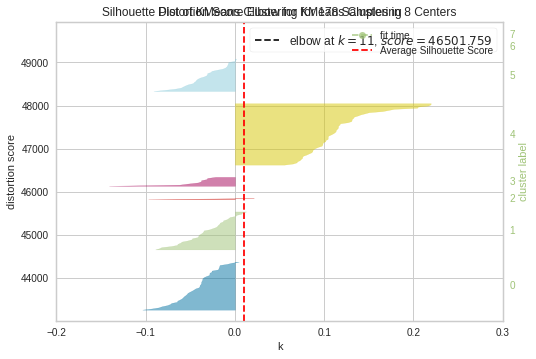

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


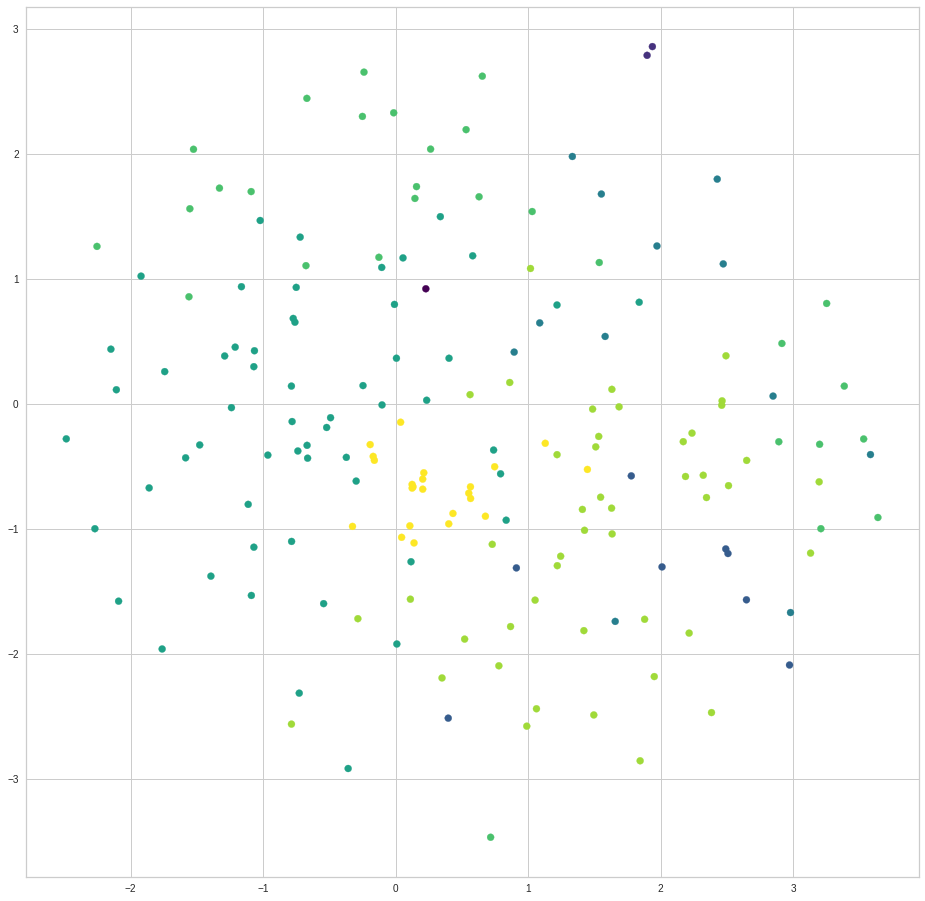

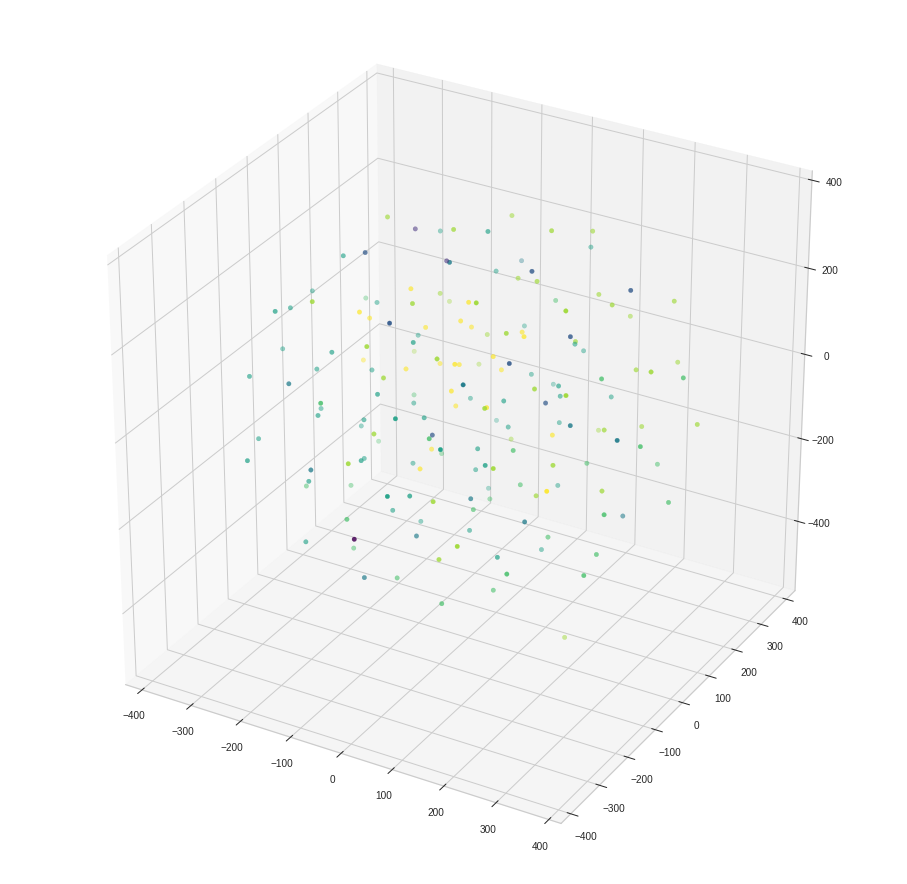

In [91]:
def bag_of_words(film_char_bags, film_char, relation):
 return [1 if token in film_char_bags[film_char][relation] else 0 for token in vocabulary]
run_method(bag_of_words, 8, (4, 20))

178 3 6920


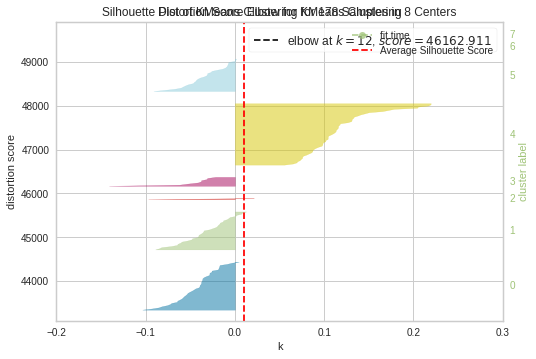

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


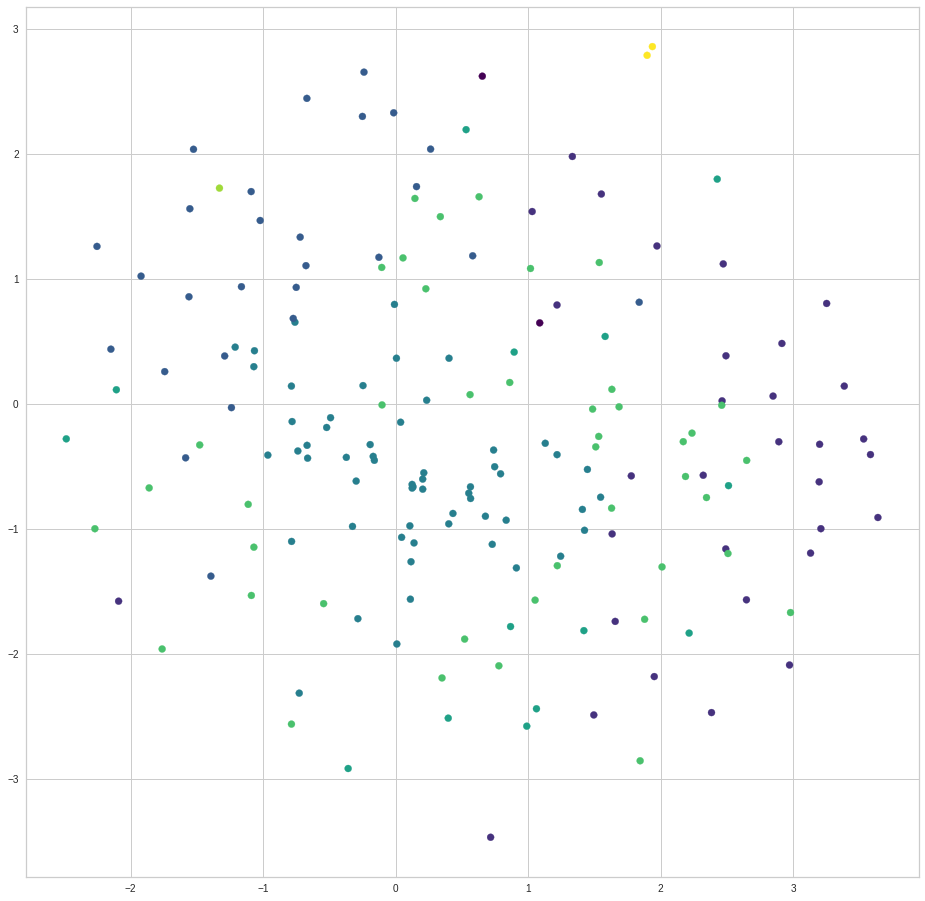

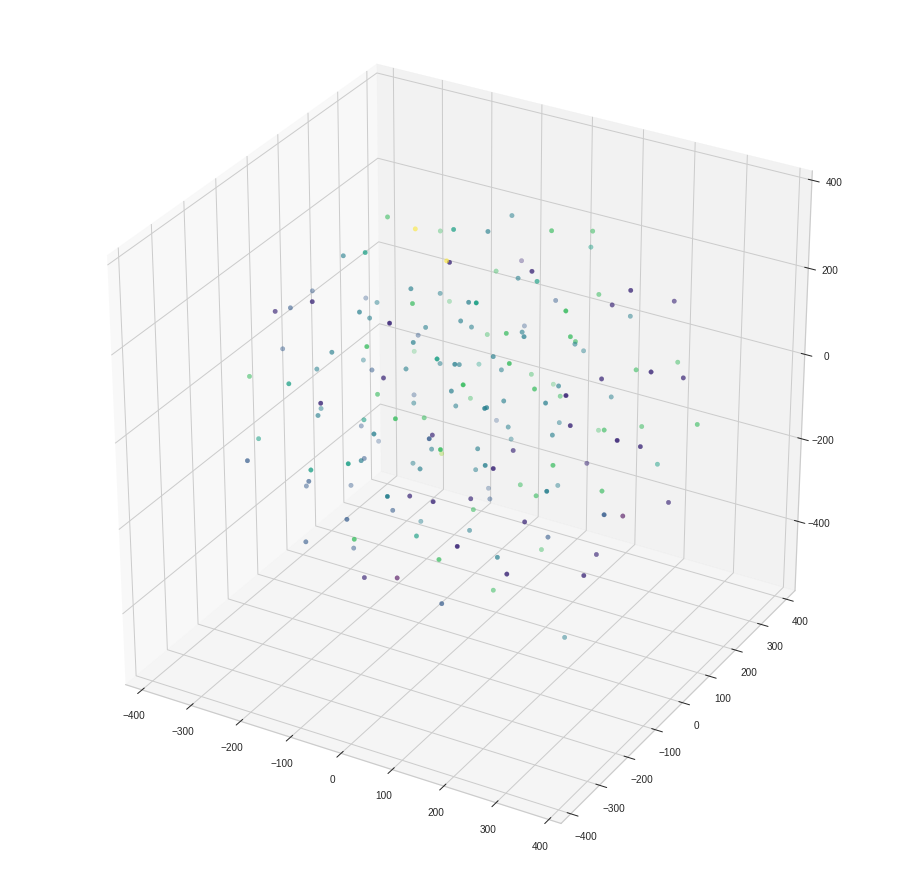

In [92]:
run_method(bag_of_words, 8, (4, 20))

178 3 6920


/usr/local/lib/python3.7/dist-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.7/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


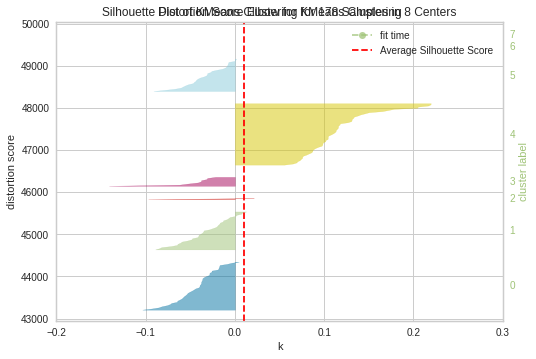

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


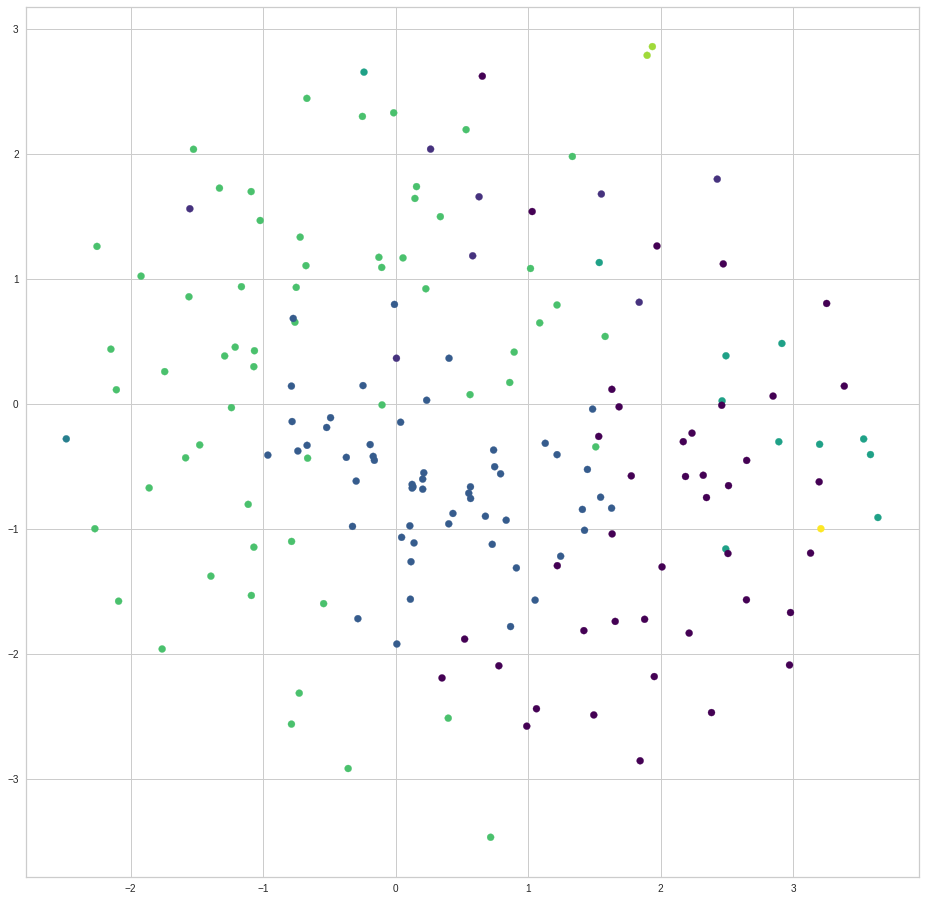

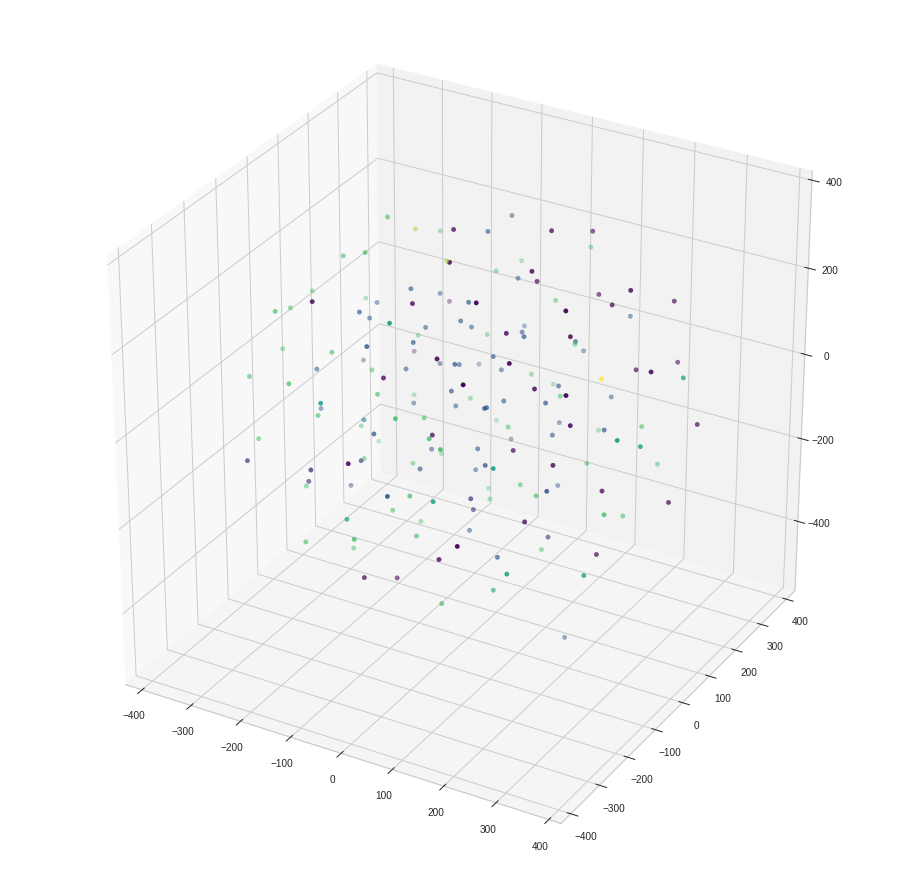

In [93]:
run_method(bag_of_words, 8, (4, 20))

178 3 100


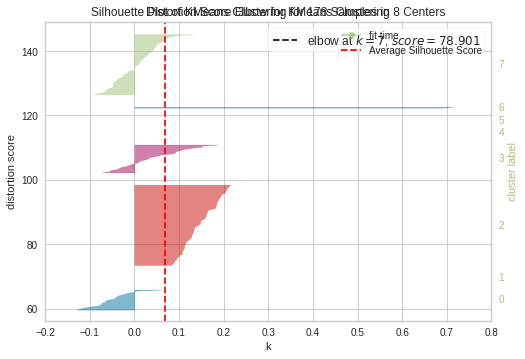

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


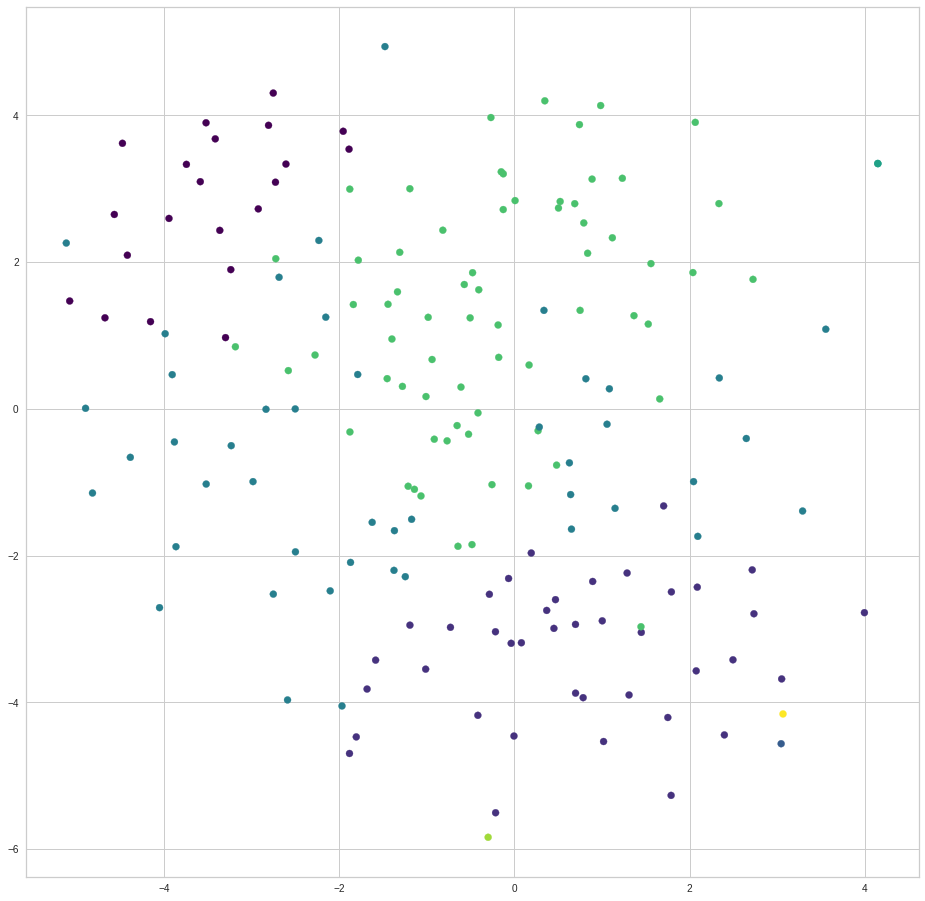

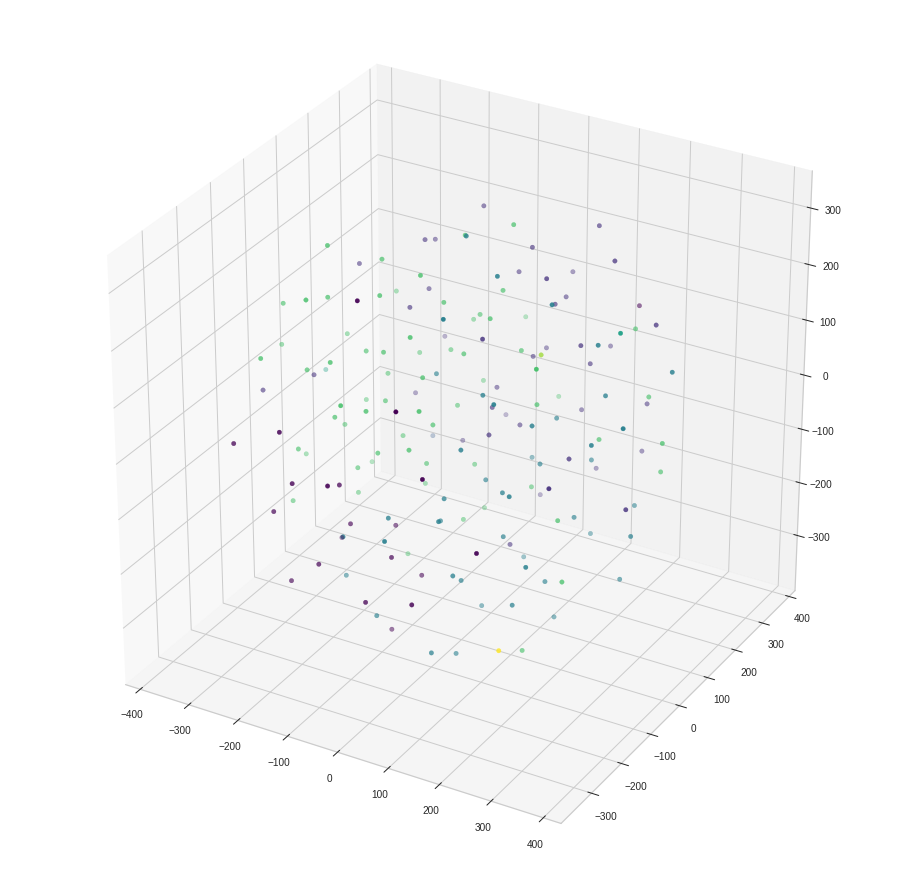

In [94]:
def glovec(film_char_bags, film_char, relation):
  return np.mean([glove[token] for token in film_char_bags[film_char][relation] if token in glove], axis=0).tolist()

run_method(glovec, 8, (1, 20))

In [ ]:
run_method(glovec, 8, (1, 20))

In [ ]:
run_method(glovec, 8, (1, 20))

In [ ]:
import math
def tf_idf(film_bags, film, relation):
  ret = []
  for token in vocabulary:
    if token in film_bags[film][relation]:
      tf = film_bags[film][relation][token]
      N = len(film_bags[film])
      n = len(vocabulary_idf[relation][token])
      idf = math.log(N/n) 
      ret.append(tf*idf)
    else:
      ret.append(0)
  return ret

run_method(tf_idf, 8, (1, 20))

In [ ]:
run_method(tf_idf, 8, (1, 20))

In [ ]:
run_method(tf_idf, 4, (1, 20))

In [ ]:
df = df_dev
relations = [ "xAttr",  "MotivatedByGoal", "xReact"]
vocabulary = set()
vocabulary_idf = {"xAttr": {},  "MotivatedByGoal": {}, "xReact": {}}
film_char_bags = {}
df.apply(process_results, axis=1)

run_method(tf_idf, 8, (1, 20))